This document focuses on analyzing the results and presenting the diagrams for the network model.     
The network model contains two intersections consisting of one east-west road and two north-south roads together.    
as control variables to reduce the pressure on the program to run and increase the efficiency of the algorithm. In this model, all roads will be considered for one-way traffic only.   


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

In [7]:
# Define a mapping for renaming columns with special characters
column_mapping = {
    '[run number]': 'run_number',
    'traffic-flow-from-west': 'traffic_flow_from_west',
    'max-accel': 'max_accel',
    'cool-down': 'cool_down',
    'bonus-delay': 'bonus_delay',
    'time-window': 'time_window',
    'traffic-flow-from-south': 'traffic_flow_from_south',
    'traffic-flow-from-north': 'traffic_flow_from_north',
    'signal-NS?': 'signal_NS',
    'speed-limit': 'speed_limit',
    'max-brake': 'max_brake',
    'traffic-flow-from-east': 'traffic_flow_from_east',
    '[step]': 'step',
    'time': 'time',
    'avg_reward': 'avg_reward',
    'pass-car': 'pass_car',
    'average-speed': 'average_speed',
    'average-wait': 'average_wait',
    'average-drive': 'average_drive',
    'switch-probability': 'switch_probability',
    'signal1-NS?': 'signal1_NS',
    'signal2-NS?': 'signal2_NS'
}

## Functions

In [3]:
def getBoxplots(df):
    columns_to_plot = df.columns.to_list()

    # Plot the box plots
    plt.figure(figsize=(12, 6))

    for i, column in enumerate(columns_to_plot, 1):
        plt.subplot(1, len(columns_to_plot), i)
        plt.boxplot(df[column])
        plt.xlabel(column)
        plt.ylabel('Values')
        plt.title(f'Box Plot for {column}')
        plt.grid(True, axis='y', linestyle='--')

        # Calculate statistics for each column
        column_max = df[column].max()
        column_min = df[column].min()
        column_mean = df[column].mean()

        # Add text annotations for mean, max, and min values
        plt.text(1, column_mean, f"Mean: {column_mean:.2f}", ha='center', va='bottom', color='red')
        plt.text(1, column_max, f"Max: {column_max}", ha='center', va='bottom', color='blue')
        plt.text(1, column_min, f"Min: {column_min}", ha='center', va='top', color='green')
    plt.tight_layout()
    plt.show()


In [4]:
def getTrend(df_bd):
    # List of columns to plot
    columns_to_plot = ['avg_reward', 'pass_car', 'average_speed', 'average_wait', 'average_drive']

    # Plot each column separately
    plt.figure(figsize=(12, 10))

    for i, column in enumerate(columns_to_plot, 1):
        plt.subplot(5, 1, i)
        plt.scatter(df_bd.index, df_bd[column], marker='o',s=1)
        plt.xlabel('step')
        plt.ylabel(column)
        plt.title(f'{column} trend during training')
        plt.grid(True, linestyle='--')
        # Fit a linear regression line
        z = np.polyfit(df_bd.index, df_bd[column], 5)
        p = np.poly1d(z)
        plt.plot(df_bd.index, p(df_bd.index), color='red')


    plt.tight_layout()
    plt.show()

In [5]:
def readBD_CSV(filepath):

    # Define a mapping of current column names to standardized column names
    column_mapping = {
        '[run number]': 'run_number',
        'cool-down': 'cool_down',
        'traffic-flow-from-west': 'traffic_flow_from_west',
        'max-accel': 'max_accel',
        'bonus-delay': 'bonus_delay',
        'traffic-flow-from-north1': 'traffic_flow_from_north1',
        'traffic-flow-from-north2': 'traffic_flow_from_north2',
        'time-window': 'time_window',
        'signal2-NS?': 'signal2_NS',
        'switch-probability': 'switch_probability',
        'speed-limit': 'speed_limit',
        'max-brake': 'max_brake',
        'signal1-NS?': 'signal1_NS',
        'RL?': 'RL',
        '[step]': 'step',
        'time': 'time',
        'pass-car': 'pass_car',
        'avg_reward': 'avg_reward',
        'average-speed': 'average_speed',
        'average-wait': 'average_wait',
        'average-drive': 'average_drive'
    }

    df = pd.read_csv(filepath)
    df.rename(columns=column_mapping, inplace=True)

    # Extract the specified columns and create a new DataFrame
    selected_columns = ['step', 'time', 'pass_car', 'avg_reward', 'average_speed', 'average_wait', 'average_drive']
    df = df[selected_columns]

    # Sort the new DataFrame by the 'step' column in ascending order
    df.sort_values(by='step', inplace=True)

    # Get the index of rows where 'time' is 0
    time_zero_indices = df[df['time'] == 0].index
    time_zero_indices = time_zero_indices[1:]

    # Extract the rows before the rows with 'time' equal to 0
    rows_before_time_zero = df.loc[time_zero_indices - 1]

    # Save the result as a new DataFrame
    result_df = rows_before_time_zero.copy()

    # Recompute the DataFrame index
    result_df.reset_index(drop=True, inplace=True)

    return result_df

## Pre-define model

In this mode, Traffic Lights 1 and 2 will have a 15ticks toggle cooldown, with a 25% probability of toggling the traffic light state every tick while it is toggleable.

In [8]:
csv_pre = pd.read_csv("./model/0_double_junction_model_sample.csv")
# Rename the columns using the mapping
csv_pre.rename(columns=column_mapping, inplace=True)
# csv_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   run_number                10001 non-null  int64  
 1   cool_down                 10001 non-null  int64  
 2   traffic_flow_from_west    10001 non-null  int64  
 3   max_accel                 10001 non-null  int64  
 4   bonus_delay               10001 non-null  int64  
 5   traffic-flow-from-north1  10001 non-null  int64  
 6   traffic-flow-from-north2  10001 non-null  int64  
 7   time_window               10001 non-null  int64  
 8   signal2_NS                10001 non-null  bool   
 9   speed_limit               10001 non-null  int64  
 10  max_brake                 10001 non-null  int64  
 11  signal1_NS                10001 non-null  bool   
 12  step                      10001 non-null  int64  
 13  pass_car                  10001 non-null  int64  
 14  averag

In [12]:
pre_df = csv_pre[['pass_car', 'average_speed', 'average_wait', 'average_drive']].copy()
pre_df = pre_df[pre_df['average_wait'] != 0]
pre_df.describe()

,pass_car,average_speed,average_wait,average_drive
count,9999.000000,9999.000000,9999.000000,9999.000000
mean,55.885589,2.232707,17.510062,4.382201
std,11.071894,0.439090,8.886024,0.425862
min,11.000000,0.581941,0.428571,2.190476
25%,49.000000,1.938216,11.471825,4.129032
50%,57.000000,2.228328,15.421053,4.400000
75%,64.000000,2.515016,21.176471,4.666667
max,91.000000,4.334568,81.617647,5.800000


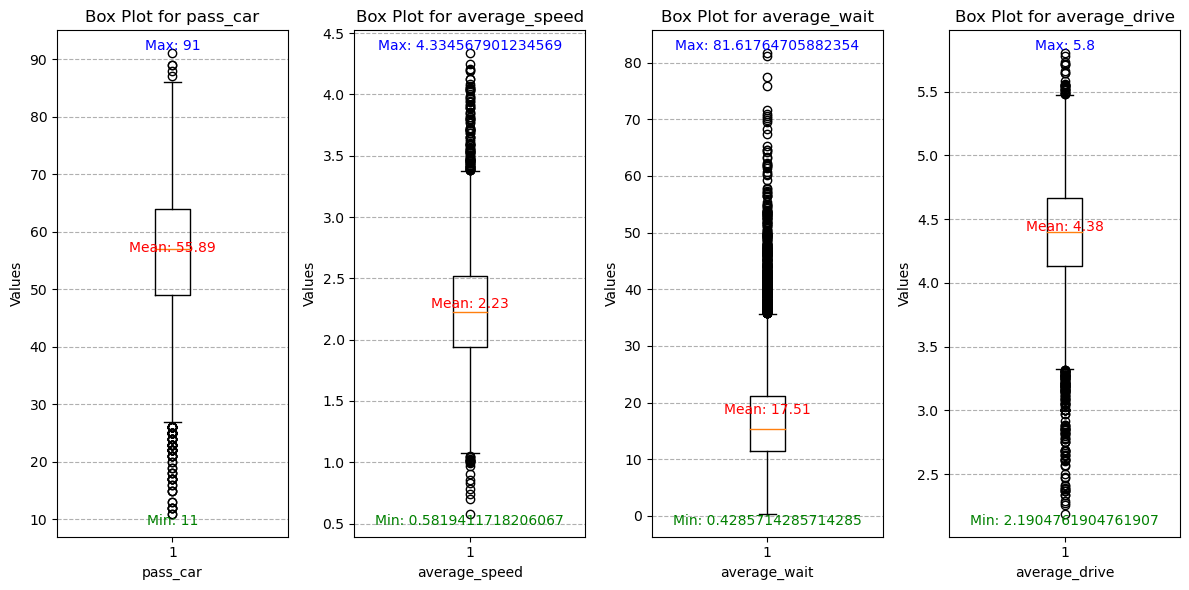

In [18]:
getBoxplots(pre_df)

## RL

### Bonus Delay 1

In [29]:
db_1 = readBD_CSV('./model/0_double_junction_model_RL-BD-1-table.csv')
db_1.rename(columns=column_mapping, inplace=True)

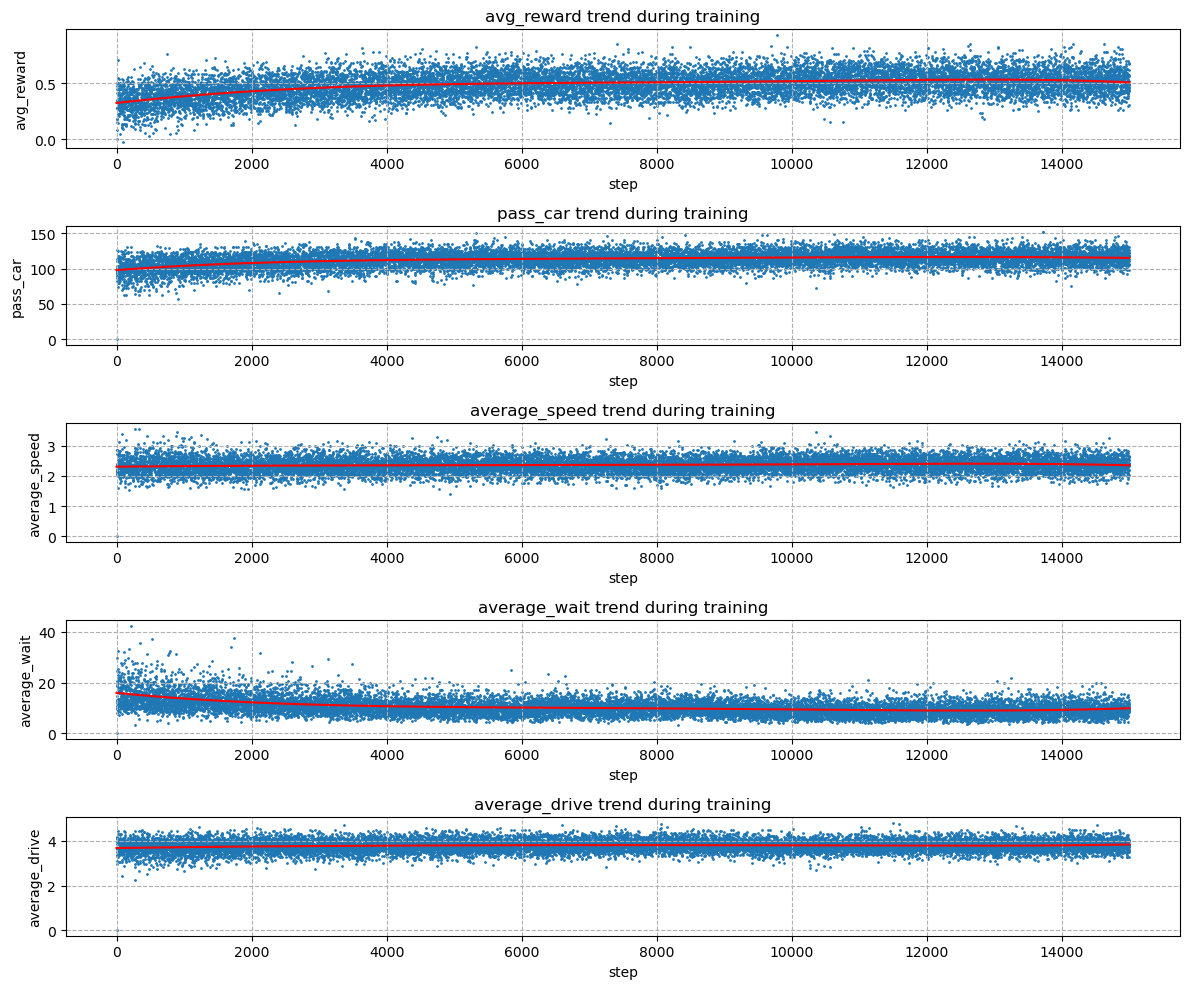

In [30]:
getTrend(db_1)

In [41]:
db_1.tail(100).describe()

,step,time,pass_car,avg_reward,average_speed,average_wait,average_drive
count,1.000000e+02,100.0,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.690910e+06,190.0,116.420000,0.501194,2.386163,9.473942,3.779891
std,5.222069e+03,0.0,9.873114,0.093529,0.224743,2.197980,0.215855
min,2.682000e+06,190.0,92.000000,0.262483,1.776155,4.388889,3.252252
25%,2.686455e+06,190.0,108.750000,0.432751,2.237827,8.008980,3.654159
50%,2.690910e+06,190.0,117.000000,0.499329,2.369267,9.343096,3.780702
75%,2.695365e+06,190.0,123.000000,0.565093,2.551845,10.602594,3.915546
max,2.699820e+06,190.0,139.000000,0.700717,2.862451,15.676768,4.322034


In [32]:
db_1.tail(100).describe() - pre_df.describe()

,average_drive,average_speed,average_wait,avg_reward,pass_car,step,time
count,-9899.000000,-9899.000000,-9899.000000,NaN,-9899.000000,NaN,NaN
mean,-0.602310,0.153457,-8.036120,NaN,60.534411,NaN,NaN
std,-0.210007,-0.214347,-6.688045,NaN,-1.198779,NaN,NaN
min,1.061776,1.194214,3.960317,NaN,81.000000,NaN,NaN
25%,-0.474873,0.299611,-3.462845,NaN,59.750000,NaN,NaN
50%,-0.619298,0.140939,-6.077957,NaN,60.000000,NaN,NaN
75%,-0.751121,0.036829,-10.573876,NaN,59.000000,NaN,NaN
max,-1.477966,-1.472117,-65.940879,NaN,48.000000,NaN,NaN


### Analysis

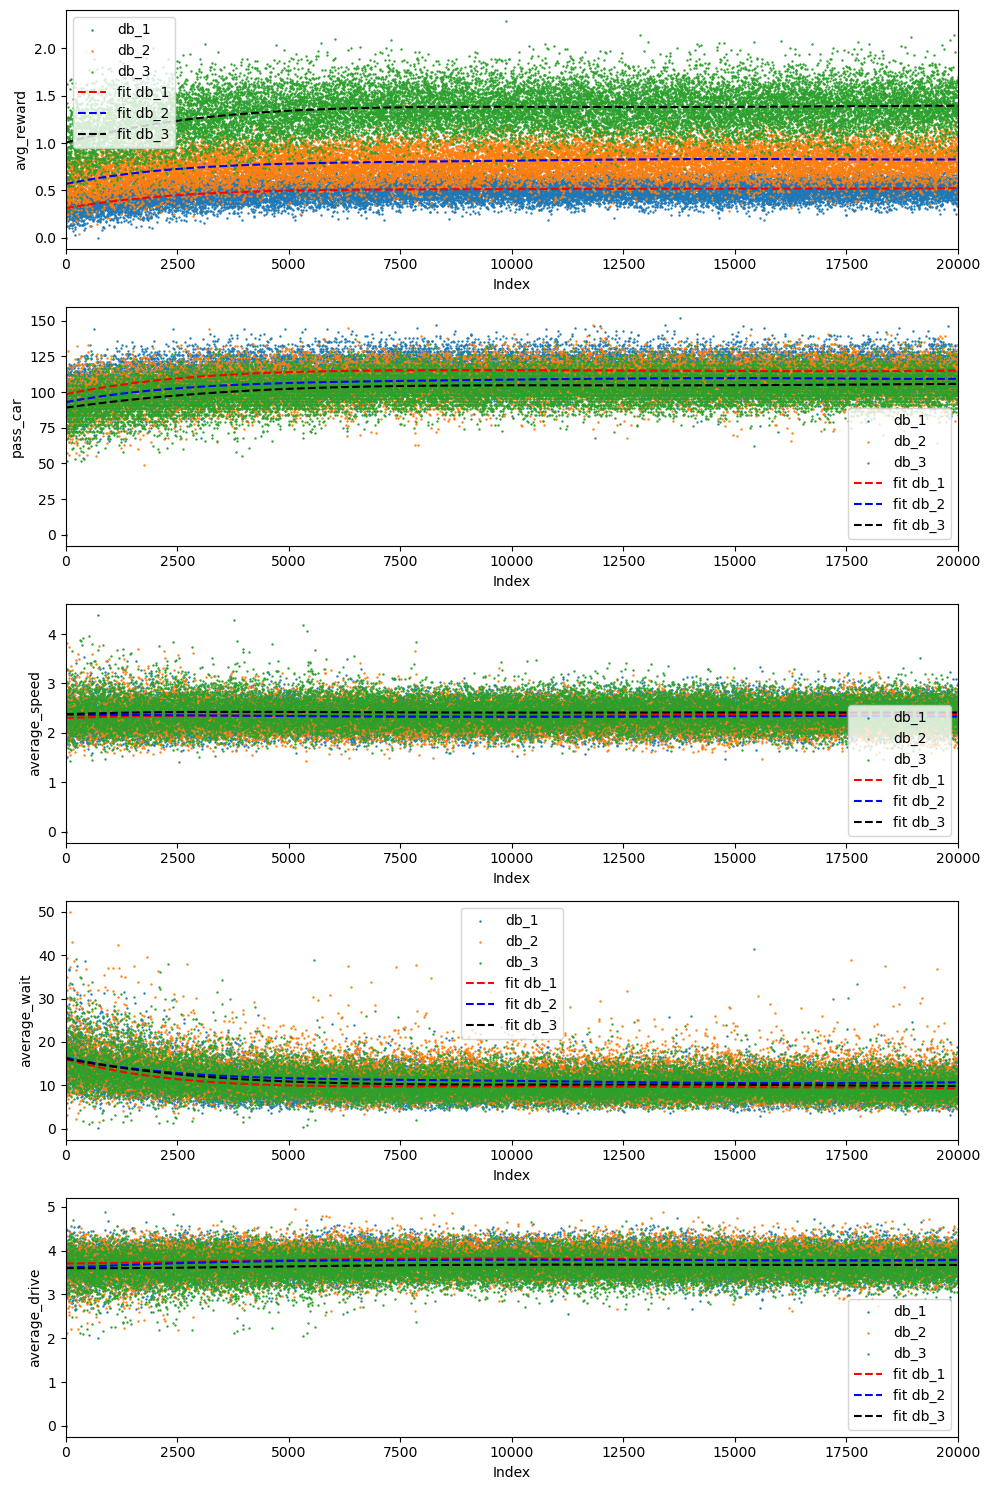

In [21]:
# # 列表中的列名
# columns = ['avg_reward', 'pass_car', 'average_speed', 'average_wait', 'average_drive']

# # 创建一个包含5个子图的画布
# fig, axes = plt.subplots(5, 1, figsize=(10, 15))

# # 循环处理每一列
# for idx, column in enumerate(columns):
#     # 在每个子图中绘制三个df的数据
#     x1 = np.arange(len(db_1))
#     x2 = np.arange(len(db_2))
#     x3 = np.arange(len(db_3))
#     y1 = db_1[column]
#     y2 = db_2[column]
#     y3 = db_3[column]

#     # 使用np.polyfit计算拟合多项式系数
#     coeffs1 = np.polyfit(x1, y1, 5)
#     coeffs2 = np.polyfit(x2, y2, 5)
#     coeffs3 = np.polyfit(x3, y3, 5)

#     # 计算拟合值
#     poly1 = np.poly1d(coeffs1)
#     poly2 = np.poly1d(coeffs2)
#     poly3 = np.poly1d(coeffs3)

#     # 绘制折线图
#     axes[idx].scatter(x1, y1, label='db_1', marker='o', s=0.5)
#     axes[idx].scatter(x2, y2, label='db_2', marker='o', s=0.5)
#     axes[idx].scatter(x3, y3, label='db_3', marker='o', s=0.5)

#     # 绘制拟合曲线
#     x_fit1 = np.linspace(0, len(db_1) - 1, 100)
#     x_fit2 = np.linspace(0, len(db_2) - 1, 100)
#     x_fit3 = np.linspace(0, len(db_3) - 1, 100)
#     axes[idx].plot(x_fit1, poly1(x_fit1), linestyle='--', label='fit db_1', color = 'red')
#     axes[idx].plot(x_fit2, poly2(x_fit2), linestyle='--', label='fit db_2', color = 'blue')
#     axes[idx].plot(x_fit3, poly3(x_fit3), linestyle='--', label='fit db_3', color = 'black')

#     axes[idx].set_xlabel('Index')
#     axes[idx].set_ylabel(column)
#     # 设置x轴范围为0到20000
#     axes[idx].set_xlim(0, 20000)
#     axes[idx].legend()

# plt.tight_layout()
# plt.show()

## Pattern of RL

In [87]:
df = pd.read_csv('./model/network_data_RL_BD_1_signal_pattern.csv')
# Define a mapping of current column names to standardized column names
column_mapping = {
        '[run number]': 'run_number',
        'cool-down': 'cool_down',
        'traffic-flow-from-west': 'traffic_flow_from_west',
        'max-accel': 'max_accel',
        'bonus-delay': 'bonus_delay',
        'traffic-flow-from-north1': 'traffic_flow_from_north1',
        'traffic-flow-from-north2': 'traffic_flow_from_north2',
        'time-window': 'time_window',
        'signal2-NS?': 'signal2_NS',
        'switch-probability': 'switch_probability',
        'speed-limit': 'speed_limit',
        'max-brake': 'max_brake',
        'signal1-NS?': 'signal1_NS',
        'RL?': 'RL',
        '[step]': 'step',
        'time': 'time',
        'pass-car': 'pass_car',
        'avg_reward': 'avg_reward',
        'average-speed': 'average_speed',
        'average-wait': 'average_wait',
        'average-drive': 'average_drive',
        'singal1_EW': 'signal1_EW',
        'singal2_EW': 'signal2_EW'
    }

df.rename(columns=column_mapping, inplace=True)

# Extract the specified columns and create a new DataFrame
selected_columns = ['step', 'time', 'signal1_EW', 'signal2_EW']
df = df[selected_columns]

# Sort the new DataFrame by the 'step' column in ascending order
df.sort_values(by='step', inplace=True)

In [98]:
df['signal1_EW'] = df['signal1_EW'].replace(0, -1)
df['signal2_EW'] = df['signal2_EW'].replace(0, -1)

df.head()

,step,time,signal1_EW,signal2_EW
0,0,0,1,1
1,1,2,1,1
2,2,3,1,1
3,3,4,1,1
4,4,5,1,1


In [113]:
time_zero_indices = df[df['time'] == 0].index
time_zero_indices[-1000]

2528821

In [137]:
last_1000_cycles = df.loc[time_zero_indices[-500]:]
result_df = last_1000_cycles.groupby('time')[['signal1_EW', 'signal2_EW']].mean()
result_df = result_df.reset_index()

In [138]:
last_1000_cycles

,step,time,signal1_EW,signal2_EW
2618821,2618821,0,1,1
2618822,2618822,1,1,1
2618823,2618823,2,1,1
2618824,2618824,3,1,1
2618825,2618825,4,1,1
...,...,...,...,...
2708638,2708638,188,1,-1
2708639,2708639,189,1,-1
2708640,2708640,190,1,-1
2708641,2708641,0,1,1


In [139]:
result_df.describe()

,time,signal1_EW,signal2_EW
count,180.000000,180.000000,180.000000
mean,95.000000,-0.026365,-0.003317
std,55.556102,0.050617,0.032438
min,0.000000,-0.122244,-0.062124
25%,47.500000,-0.042084,-0.024533
50%,95.000000,-0.010020,-0.006012
75%,142.500000,0.000000,0.024048
max,190.000000,0.048000,0.050100


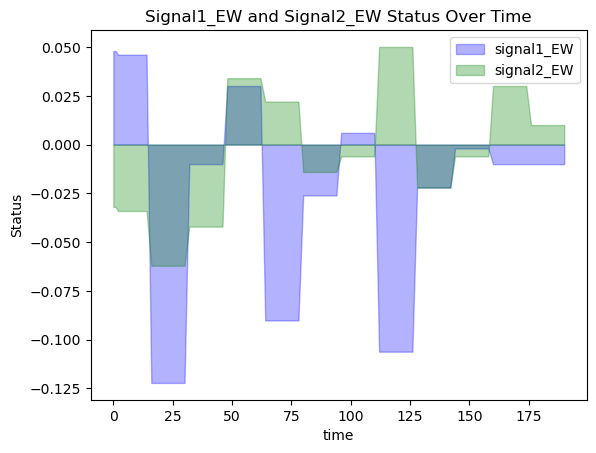

In [140]:
# 提取time、signal1_EW和signal2_EW的值
time = result_df['time']
signal1_EW = result_df['signal1_EW']
signal2_EW = result_df['signal2_EW']

# 创建绘图
fig, ax = plt.subplots()

# 绘制signal1_EW的状态
ax.fill_between(time, signal1_EW, color='blue', alpha=0.3, label='signal1_EW')

# 绘制signal2_EW的状态
ax.fill_between(time, signal2_EW, color='green', alpha=0.3, label='signal2_EW')

# 设置图表标题和轴标签
ax.set_title('Signal1_EW and Signal2_EW Status Over Time')
ax.set_xlabel('time')
ax.set_ylabel('Status')

# 添加图例
ax.legend()

# 显示图表
plt.show()

## Simulation

In [24]:
csv_simu = pd.read_csv('./model/0_double_junction_model_simu.csv')
csv_simu.rename(columns=column_mapping, inplace=True)

In [25]:
simu_df = csv_simu[['pass_car', 'average_speed', 'average_wait', 'average_drive']].copy()
simu_df = simu_df[simu_df['average_wait'] != 0]
simu_df.describe()

,pass_car,average_speed,average_wait,average_drive
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,93.541800,2.350051,14.794483,3.649851
std,12.195422,0.313167,5.337525,0.330952
min,36.000000,1.410209,0.620000,2.121951
25%,86.000000,2.139791,11.211765,3.453158
50%,94.000000,2.325249,13.887745,3.677969
75%,102.000000,2.526431,17.453608,3.871414
max,137.000000,4.228628,53.153846,4.737374


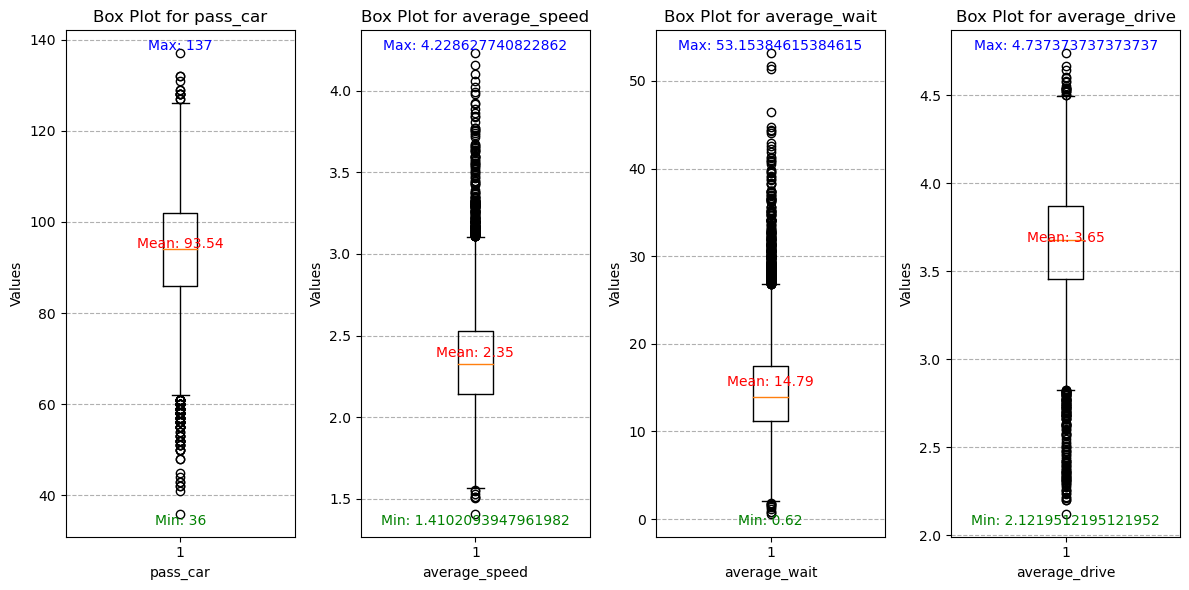

In [26]:
getBoxplots(simu_df)

In [48]:
csv_simu_bd_1 = readBD_CSV('./model/0_double_junction_model_RL-BD-1-sample-table.csv')
csv_simu_bd_1.rename(columns=column_mapping, inplace=True)

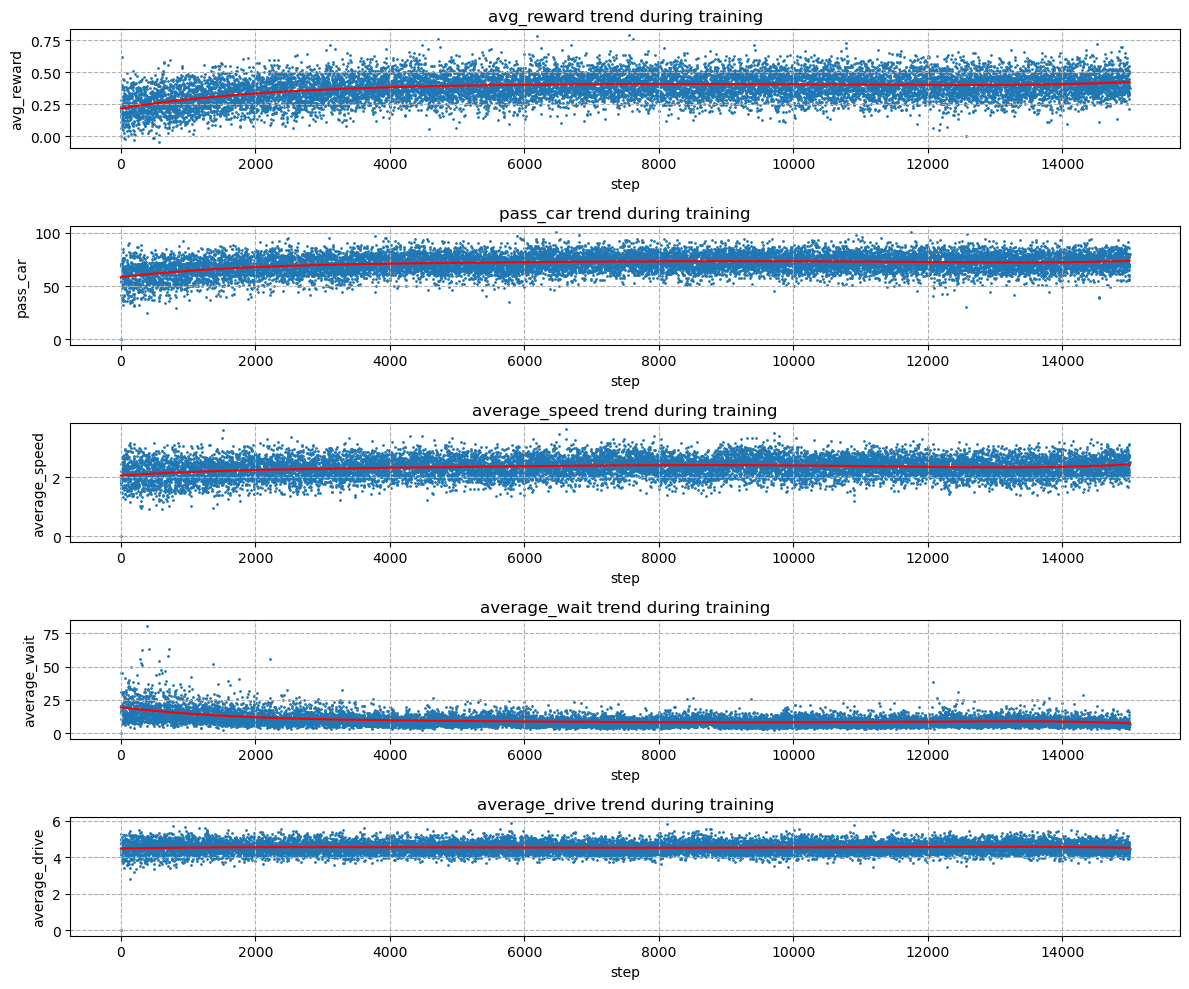

In [49]:
getTrend(csv_simu_bd_1)

In [50]:
csv_simu_bd_1.tail(100).describe()

,step,time,pass_car,avg_reward,average_speed,average_wait,average_drive
count,1.000000e+02,100.0,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.690910e+06,190.0,73.040000,0.424792,2.442179,7.766126,4.498540
std,5.222069e+03,0.0,8.280341,0.089972,0.303303,2.660238,0.289042
min,2.682000e+06,190.0,55.000000,0.212960,1.685459,3.471429,3.891892
25%,2.686455e+06,190.0,68.000000,0.360786,2.233546,6.036381,4.311756
50%,2.690910e+06,190.0,73.000000,0.421137,2.425145,7.319722,4.476901
75%,2.695365e+06,190.0,78.250000,0.495386,2.669594,9.063313,4.701034
max,2.699820e+06,190.0,91.000000,0.645859,3.143792,17.821918,5.304348


In [51]:
csv_simu_bd_1.tail(100).describe() - simu_df.describe()

,average_drive,average_speed,average_wait,avg_reward,pass_car,step,time
count,-9900.000000,-9900.000000,-9900.000000,NaN,-9900.000000,NaN,NaN
mean,0.848689,0.092128,-7.028357,NaN,-20.501800,NaN,NaN
std,-0.041910,-0.009864,-2.677287,NaN,-3.915082,NaN,NaN
min,1.769941,0.275249,2.851429,NaN,19.000000,NaN,NaN
25%,0.858598,0.093755,-5.175384,NaN,-18.000000,NaN,NaN
50%,0.798932,0.099895,-6.568023,NaN,-21.000000,NaN,NaN
75%,0.829620,0.143163,-8.390295,NaN,-23.750000,NaN,NaN
max,0.566974,-1.084836,-35.331928,NaN,-46.000000,NaN,NaN
